In [1]:
# https://www.kaggle.com/code/akshitsharma1/generative-adversarial-networks-gan-in-one-shot/notebook
# https://www.kaggle.com/code/bjoernjostein/gan-on-ecg
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms as T

import torch.nn as nn


from __future__ import print_function
import time

import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from skimage.transform import resize

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Classifies all images in folder given model 
def process_images(path):
    processed_images  = []
    # Prepare to process image
    transform = T.Compose([T.Resize(256),T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    dir_list = os.listdir(path)
    for file_name in dir_list: 
        img=Image.open(path+file_name).convert('RGB')
        img_t = transform(img)
        batch_t = torch.unsqueeze(img_t, 0)
        processed_images.append (batch_t) 
    return processed_images


def get_labels(path):
    processed_images, labels = [], []
    processed_images += process_images(path+'F/')
    labels = ['F' for f in range(len(processed_images))]
    processed_images+= process_images(path+'N/')
    diff = len(processed_images)-len(labels)
    labels += ['N' for n in range(diff)]
    processed_images+= process_images(path+'Q/')
    diff = len(processed_images)-len(labels)
    labels += ['Q' for q in range(diff)]
    processed_images+= process_images(path+'S/')
    diff = len(processed_images)-len(labels)
    labels += ['S' for s in range(diff)]
    processed_images+= process_images(path+'V/')
    diff = len(processed_images)-len(labels)
    labels += ['V' for v in range(diff)]
    len(labels) == len(processed_images) # sanitychheck 
    return processed_images, labels 



In [3]:
def process2(path):
    processed_images2=[]
    image_size = 64
    batch_size = 32
    random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
    transform = transforms.Compose([transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomApply(random_transforms, p=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dir_list = os.listdir(path)
    for file_name in dir_list: 
        img=Image.open(path+file_name).convert('RGB')
        img_t = transform(img)
        batch_t = torch.unsqueeze(img_t, 0)
        processed_images2.append (batch_t) 
    return processed_images2

In [4]:
training_path = '/kaggle/input/ekg-images/ecg_images/train/'
processed_images, original_labels = get_labels(training_path)

training_path2 = training_path+'F/'
processed_images2= process2(training_path2)

train_loader = torch.utils.data.DataLoader(processed_images2, shuffle=True,batch_size=32)                                   
imgs = next(iter(train_loader)) 
imgs2 = [] # 32 
for i in imgs: 
    i = i.numpy().transpose(0,2,3,1) # index transposition for each image
    imgs2.append(i)

In [5]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block
        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh())
    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.channels = channels
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
        return out.view(-1, 1)

In [6]:
# Creating the discriminator
netD = Discriminator()
netD.apply(weights_init)

# Creating the generator
netG = Generator()
netG.apply(weights_init)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Batch

In [22]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GAN():
    def __init__(self):
# 
        self.batch_size = 32
        self.LR_G = 0.001
        self.LR_D = 0.0005

        self.beta1 = 0.5
        self.epochs = 100

        self.real_label = 0.9
        self.fake_label = 0
        self.nz = 128
        
        self.netG = Generator()
        self.netD = Discriminator()

#         self.netG = Generator().to(device)
#         self.netD = Discriminator().to(device)

        self.criterion = nn.BCELoss()

        self.optimizerD = optim.Adam(netD.parameters(), lr=self.LR_D, betas=(self.beta1, 0.999))
        self.optimizerG = optim.Adam(netG.parameters(), lr=self.LR_G, betas=(self.beta1, 0.999))

#         self.fixed_noise = torch.randn(25, self.nz, 1, 1, device=device)
        self.fixed_noise = torch.randn(25, self.nz, 1, 1)


        self.G_losses = []
        self.D_losses = []
        self.epoch_time = []
    def show_generated_img(self,n_images=5):
        sample = []
        for _ in range(n_images):
#             noise = torch.randn(1, self.nz, 1, 1, device=device)
            noise = torch.randn(1, self.nz, 1, 1)

            gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)

        figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
        for index, axis in enumerate(axes):
            axis.axis('off')
            image_array = sample[index]
            axis.imshow(image_array)

        plt.show()
        plt.close()

    def train_GAN(self,processed_images,train_labels):
        for epoch in range(self.epochs):
            print('starting epoch ', epoch, ' /', self.epochs)
            start = time.time()
#             for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            for ii,(real_images,t_s) in enumerate(zip(processed_images,train_labels)):
                netD.zero_grad()
#                 real_images = real_images.to(device)

                batch_size = real_images.size(0)
#                 labels = torch.full((self.batch_size, 1), self.real_label, device=device)
                labels = torch.full((self.batch_size, 1), self.real_label)

                output = netD(real_images)
                output = sum(output.T[0])/len(output.T[0])

#                 print("output", output)
#                 print("labels", labels[0])
                errD_real = criterion(output,labels)
                errD_real.backward()
                D_x = output.mean().item()

                # train with fake
#                 noise = torch.randn(self.batch_size, self.nz, 1, 1, device=device)
                noise = torch.randn(self.batch_size, self.nz, 1, 1)

                fake = netG(noise)
#                 labels.fill_(fake_label)
                output = netD(fake.detach())
                errD_fake = criterion(output, labels)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                self.optimizerD.step()

                netG.zero_grad()
#                 labels.fill_(real_label)  # fake labels are real for generator cost
                output = netD(fake)

                errG = criterion(output, labels)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optimizerG.step()

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

#                 if (ii+1) % (len(train_loader)//2) == 0:
#                     print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
#                           % (epoch + 1, self.epochs, ii+1, len(train_loader),
#                              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


            plot_loss (self.G_losses, self.D_losses, epoch)
            self.G_losses = []
            self.D_losses = []
#             if epoch % 2 == 0:
            print(epoch, 'image: ')
            self.show_generated_img()

#             epoch_time.append(time.time()- start)

        #             valid_image = netG(fixed_noise)

starting epoch  0  / 100


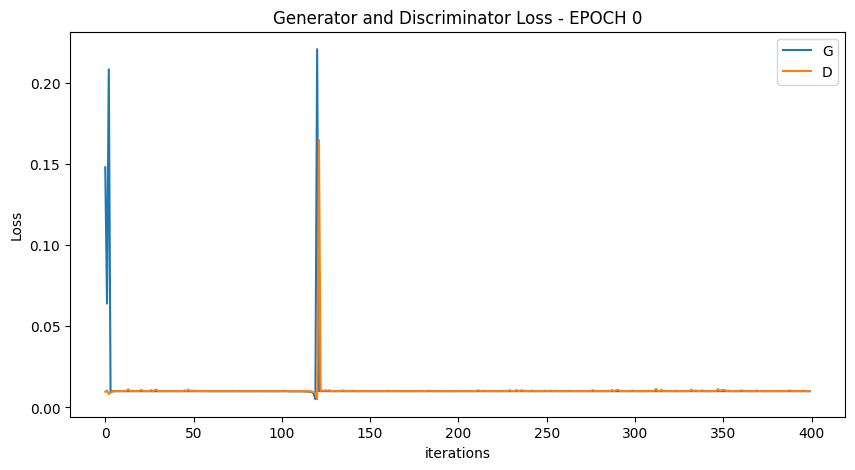

0 image: 


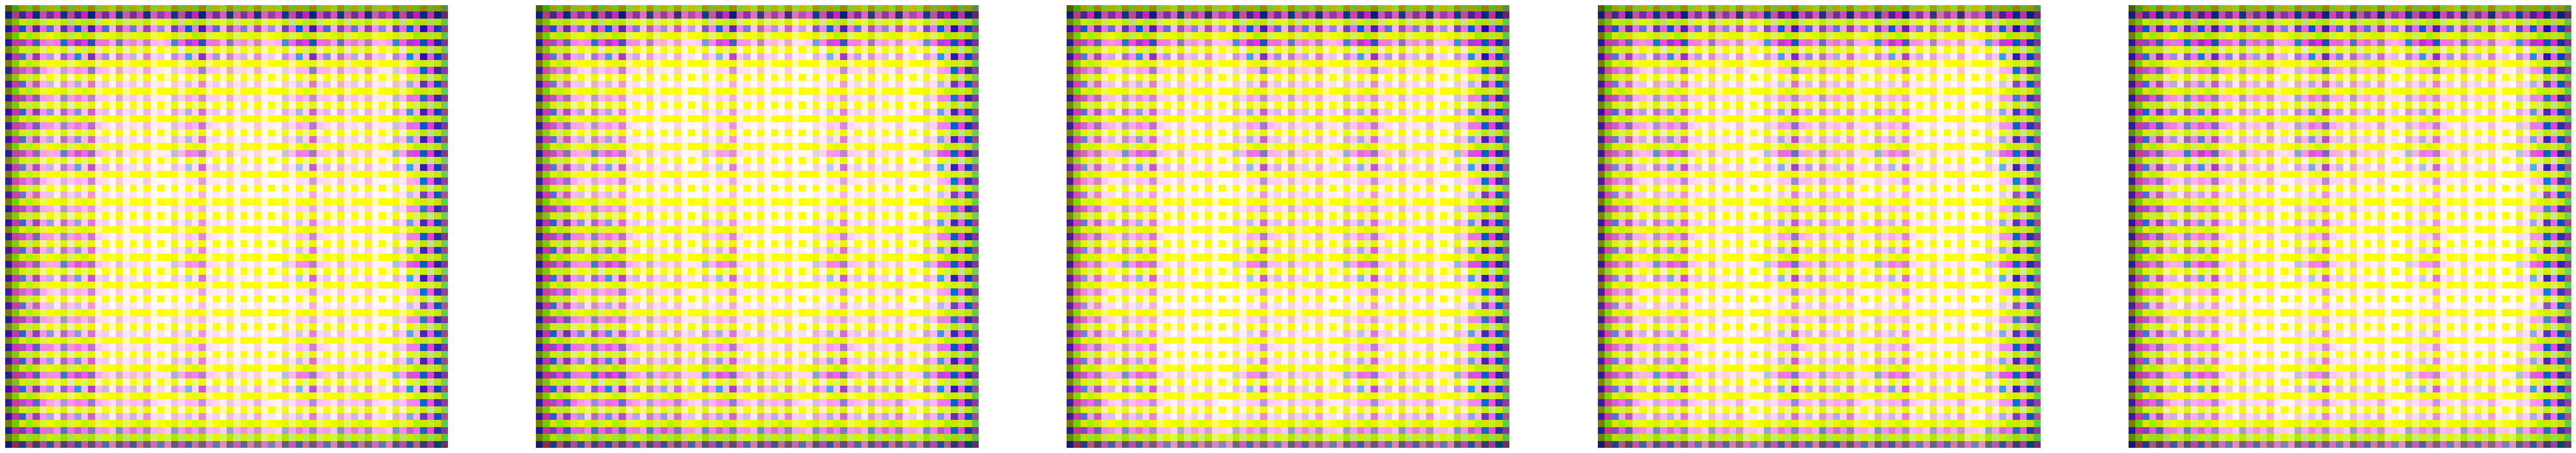

starting epoch  1  / 100


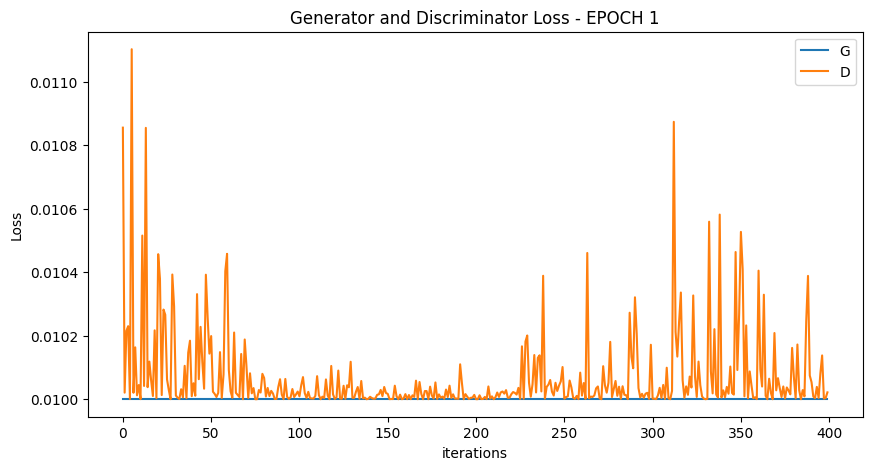

1 image: 


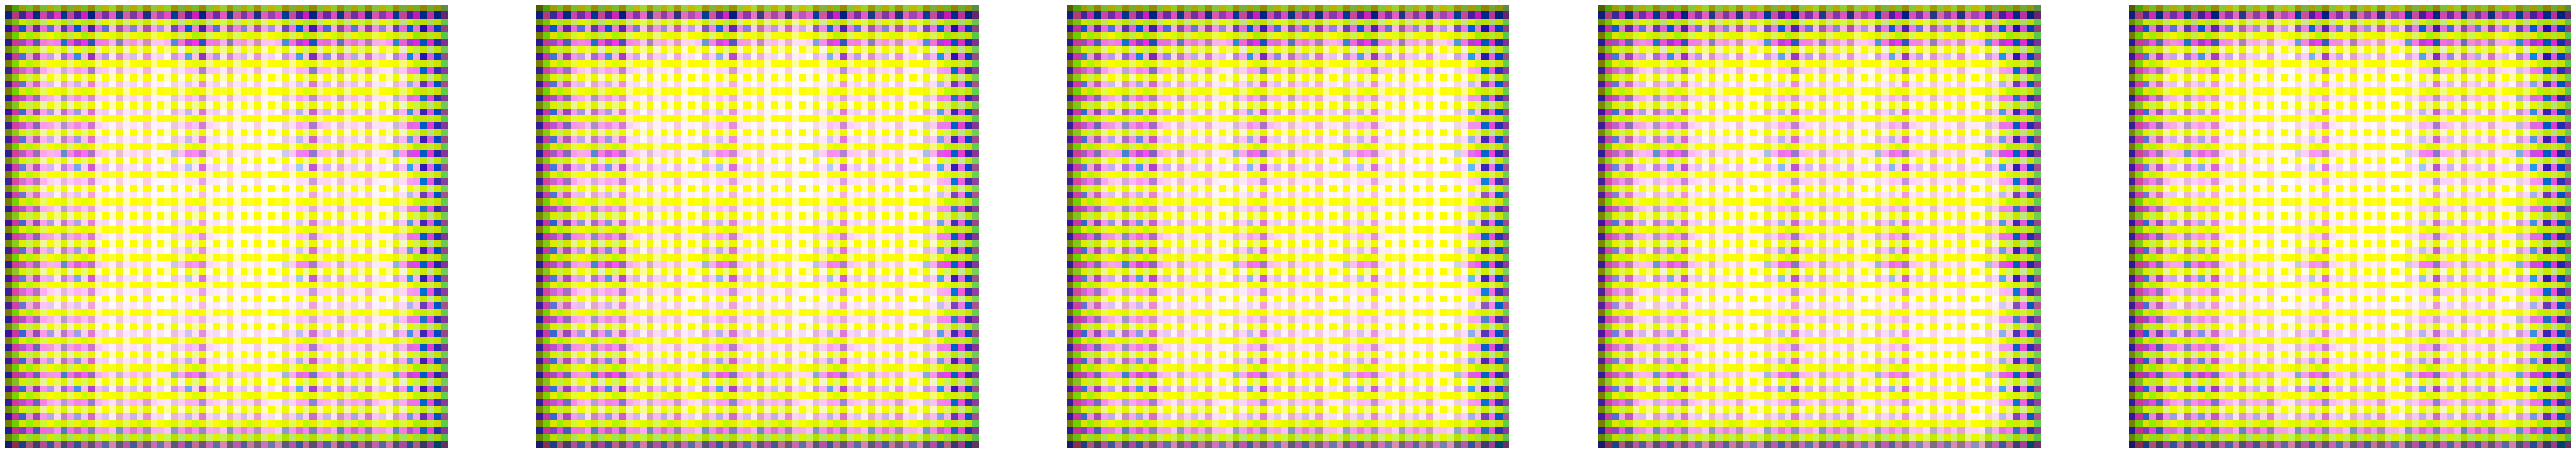

starting epoch  2  / 100


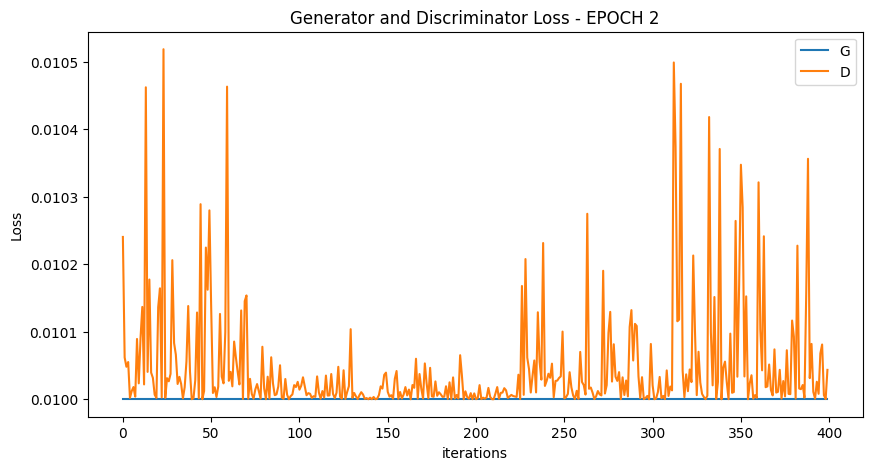

2 image: 


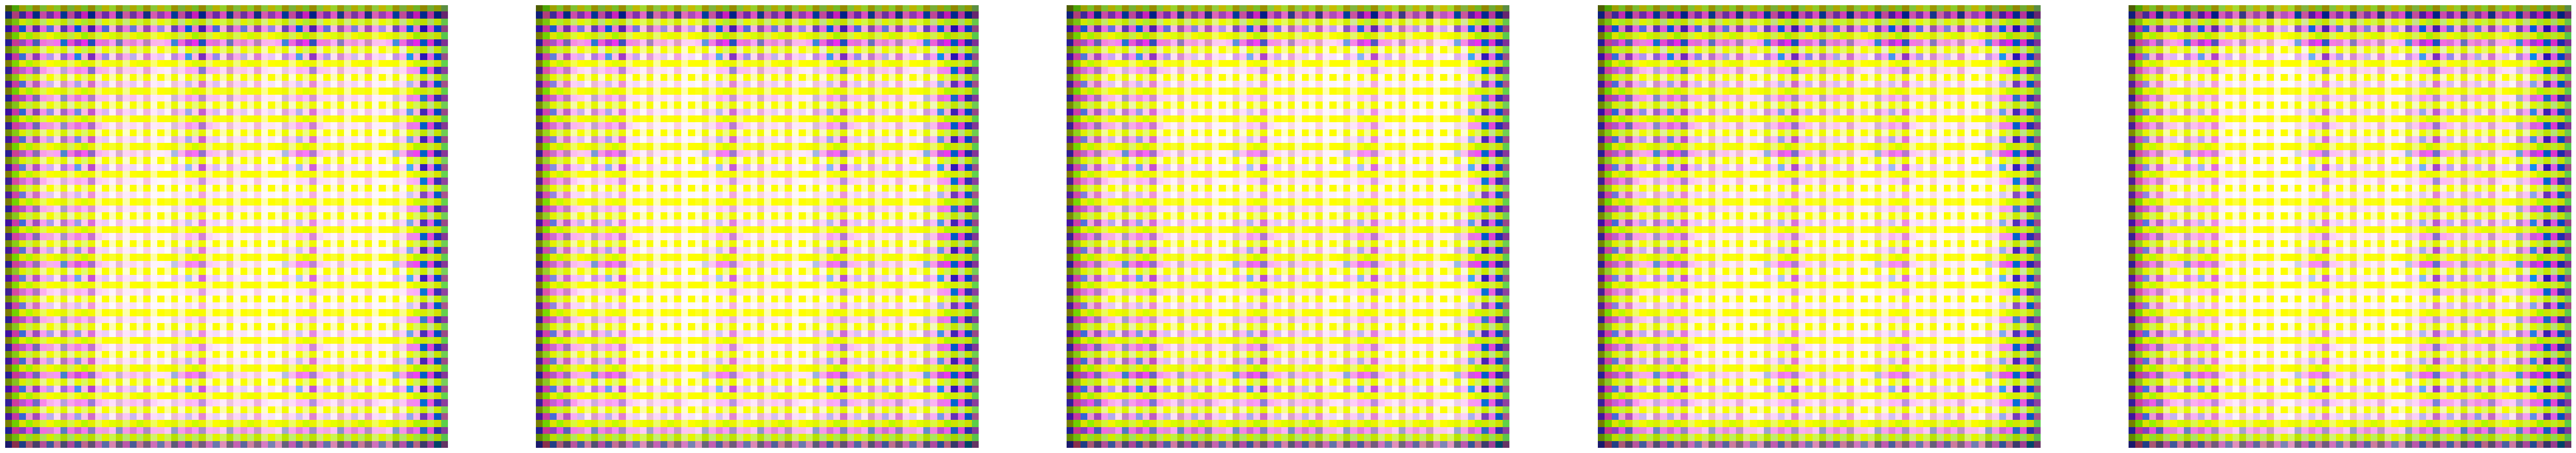

starting epoch  3  / 100


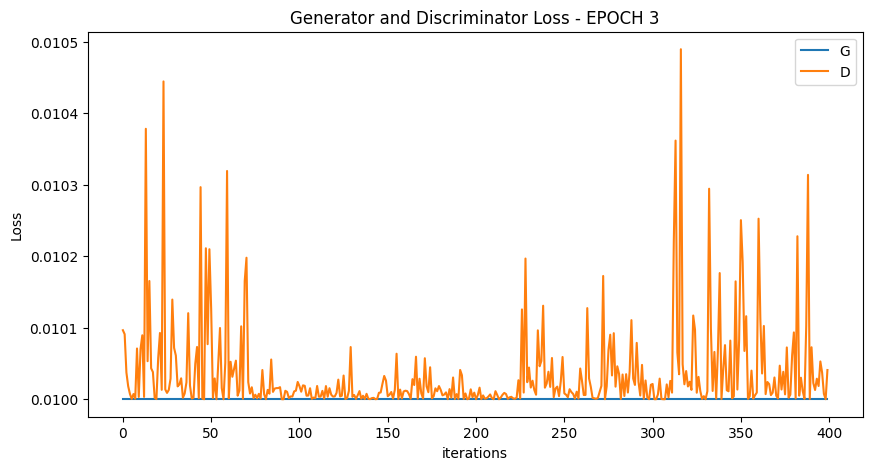

3 image: 


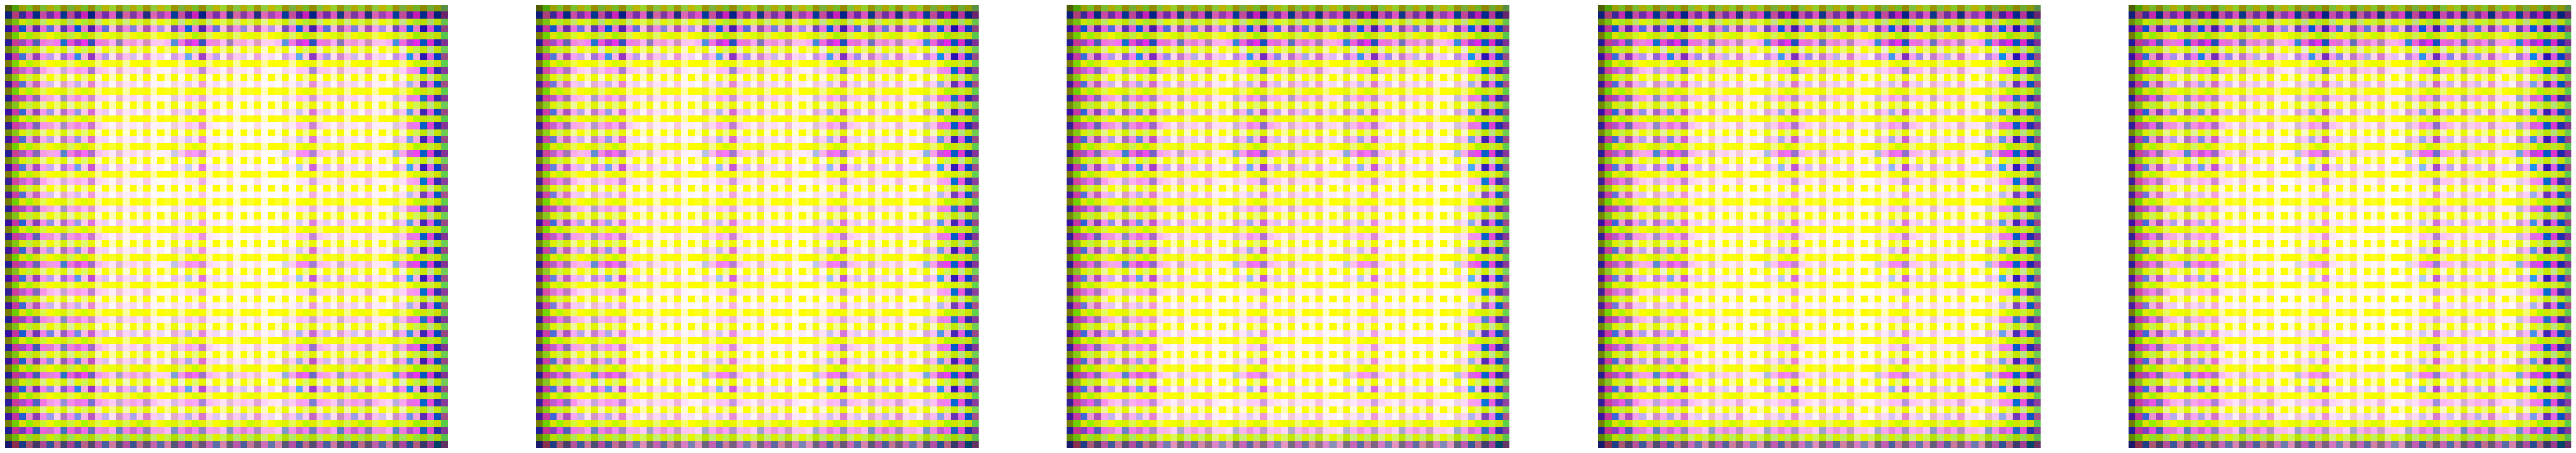

starting epoch  4  / 100


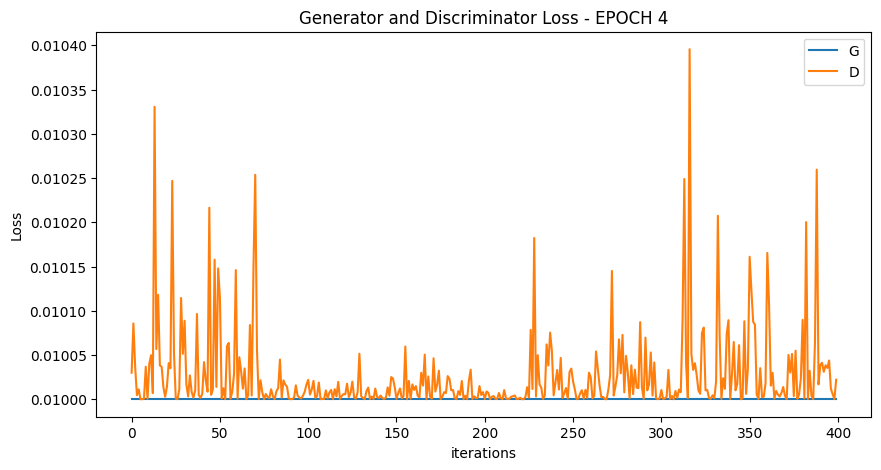

4 image: 


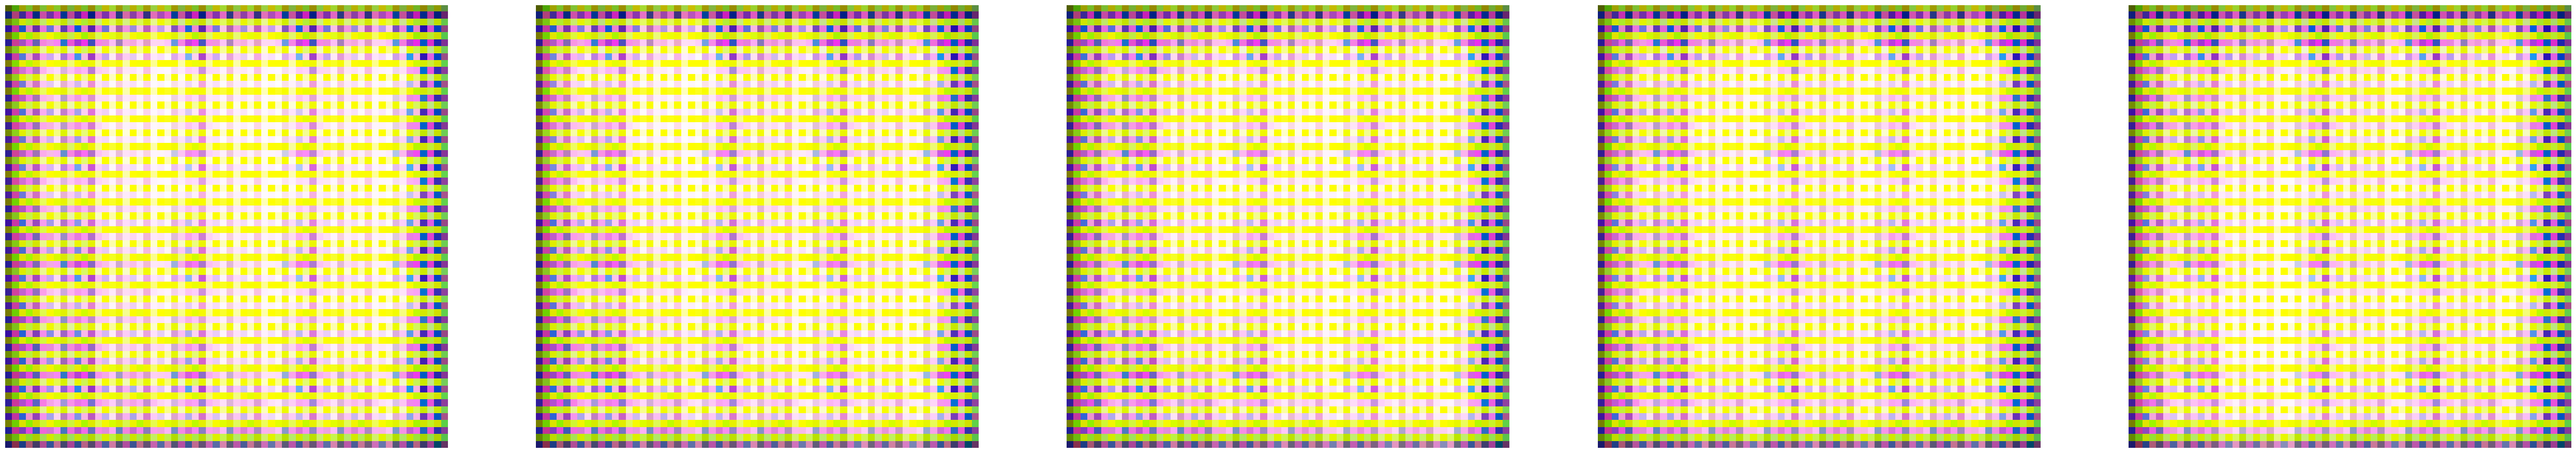

starting epoch  5  / 100


In [ ]:
criterion = nn.MSELoss()
gan1 = GAN()
gan1.train_GAN(processed_images,original_labels)